In [45]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data,augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model3
import numpy.random as rnd
from cs231n.data_utils import load_CIFAR10
from Loss_metrics import Prob_dist, YUV2rgb, assign_bin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    plt.show()
    return

In [47]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    plt.show()
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


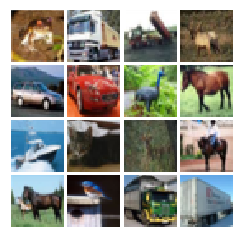

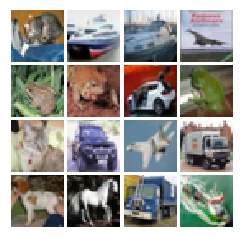

In [48]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
show_images(X_train[:16])
show_images(X_test[:16])


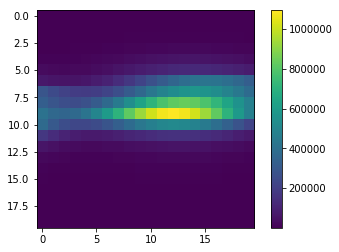

In [60]:
import scipy 
yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
dist = np.zeros([400])
X_YUV = X_train.dot(yuv_converter)
ab = assign_bin(X_YUV)
np.add.at(dist, ab, 1)
normalized = scipy.ndimage.filters.gaussian_filter(dist, 5, order=0)
lamda = 0.5
inv_wgt = (1-lamda)*normalized + lamda/400
wgt = 1/inv_wgt
plt.imshow(normalized.reshape([20,20]))
plt.colorbar()
plt.show()

In [66]:
from skimage import img_as_float

tf.reset_default_graph()

X = tf.placeholder(tf.float32 ,[None ,32,32,3])
Y = tf.placeholder(tf.float32,[None,32,32,400])
is_training = tf.placeholder(tf.bool)

with tf.variable_scope("model") as scope:
    UV_out,Y_in,UV_in = complex_pokemon_model3(X,is_training)
    reshaped_Y = tf.reshape(Y,shape = [-1,400])
    reshaped_UV_out = tf.reshape(UV_out,shape = [-1,400])
    loss_temp = tf.nn.softmax_cross_entropy_with_logits(logits = reshaped_UV_out,labels = reshaped_Y )
    weight_mat = tf.constant(wgt, shape=[400,])
    
    
    max_y = tf.argmax(Y, axis=3)
    y_reshaped = tf.reshape(max_y, shape= [-1])
    weight = weight_mat[y_reshaped]
    
    
    weight = tf.reshape(weight, shape=[-1, 32, 32])
    loss_reshaped = tf.reshape(loss_temp,[-1,32,32])
    loss = tf.reduce_mean(weight*loss_reshaped)
    train_step = (tf.train.AdamOptimizer(1e-3).minimize(loss))

sess = tf.Session()
#saver = tf.train.Saver()
#saver.restore(sess,'../models/image_net_pok_model_trained/new_model')

#import numpy.random as rnd

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10000):
    rand_indices = np.random.choice(50000,32,replace = False)
    samp = X_train[rand_indices]
    
    samp_float = img_as_float(samp)
    samp_YUV = samp_float.dot(yuv_converter)
    samp_rgb = samp_YUV.dot(inv_mat)
    prob_dist_batch = Prob_dist(samp_YUV)
    feed_dict = {X:samp, Y:prob_dist_batch, is_training:True}
    losses,UV_o,y_in,_ = sess.run([loss,UV_out,Y_in,train_step],feed_dict)
    RGB_output = YUV2rgb(UV_o, y_in)
    ### SUper chutiyaapa 0.025
     
    if(i%100==0):    
        print(i)
        #saver.save(sess,'../models/class_model/mod')
        print (losses)
        show_images2(rgb2gray(samp[:16]))
        show_images(RGB_output[:16])
        show_images(samp[:16])

ValueError: Shape must be rank 1 but is rank 2 for 'model/strided_slice_2' (op: 'StridedSlice') with input shapes: [400], [1,?], [1,?], [1].

In [ ]:

auc, ans = AUC(np.reshape(rgb_i, [48, 64, 64, 3]), np.reshape(rgb_gray, [48, 64, 64, 3]))
print(ans)

plt.plot(np.arange(0., 0.5, 0.5/256), auc)
plt.plot(np.arange(0., 0.5, 0.5/256), 1-auc)
